In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#視覺化convnet的filter
#看各filter要過濾的視覺圖案(visual pattern)
#透過改變輸入影像的像素，使filter的響應最大化(即做梯度上升gradient ascent來完成)
#先建立一個損失函數，讓convnet指定層中指定的濾波器的啟動函數輸出值最大化，然後使用隨機梯度下降(SGD)來調整影像像素值，以便最大化此啟動函數輸出值

In [3]:
#建立過濾器視覺化的損失函數張量
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K #調用keras後端功能(ex:張量操作、卷積...)
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [4]:
model = VGG16(weights='imagenet',
             include_top='False')

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:,:,:,filter_index]) #定義損失函數張量 = 層輸出張量數值取平均

553476096/553467096 [==============================] - 3s 0us/step


2022-08-21 16:27:14.763734: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
#取得損失值(loss)相對於輸入(model.input)的梯度
grads = K.gradients(loss, model.input)[0] #gradients()傳回一個由張量組成的list，此例list大小為1

In [6]:
#梯度正規化
#為確保梯度下降能順利進行，將梯度向量除以期L2 norm(梯度張量平方的平均值再取平方根)，來對梯度張量進行正規化
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5) #在除法之前先加上1e-5，避免除以0

In [7]:
#建立給定輸入張量，取得輸出張量的Keras function
iterate = K.function([model.input], [loss, grads]) #定義Keras後端函式([輸入], [輸出])

loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])
#損失張量    梯度張量                輸入張量

In [8]:
#透過隨機梯度下降實作損失最大化
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128. #從帶有雜訊的灰階影像開始

step = 1. #每個梯度更新的大小
for i in range(40): #執行梯度上升40步
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step #以朝向最大化損失，調整輸入圖像(以前SGD是用 -=，現在反過來用 +=)

In [9]:
#建立將圖像張量轉換為能顯示之影像格式的自訂函式
def deprocess_image(x):
    #張量正規化:以0為中心，確保標準差為0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1) #修正x = [0, 1]
    
    #轉換成RGB陣列
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    
    return x

In [10]:
#建立過濾器視覺化之函式
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output #取得指定層的輸出張量
    loss = K.mean(layer_output[:,:,:,filter_index]) #取得指定過濾器的輸出張量，並最大化此張量的均值作為損失
    
    grads = K.gradients(loss, model.input)[0] #根據此損失計算輸入影像的梯度
    
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5) #梯度正規化
    
    iterate = K.function([model.input], [loss, grads]) #給定輸入影像，回傳損失及梯度
    
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128. #從帶有雜訊的灰階影像開始
    
    step = 1. #每個梯度更新的大小
    for i in range(40): #執行梯度上升40步
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step #以朝向最大化損失，調整輸入圖像(以前SGD是用 -=，現在反過來用 +=)
        
    img = input_img_data[0]
    
    return deprocess_image(img) #進行圖像處理後回傳

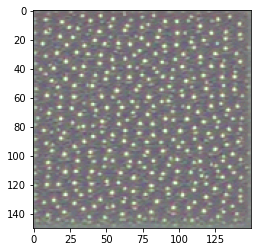

In [11]:
#block3_conv1層中過濾器0的響應圖(第0個channel的最大回應pattern)
import matplotlib.pyplot as plt
plt.imshow(generate_pattern('block3_conv1', 0))

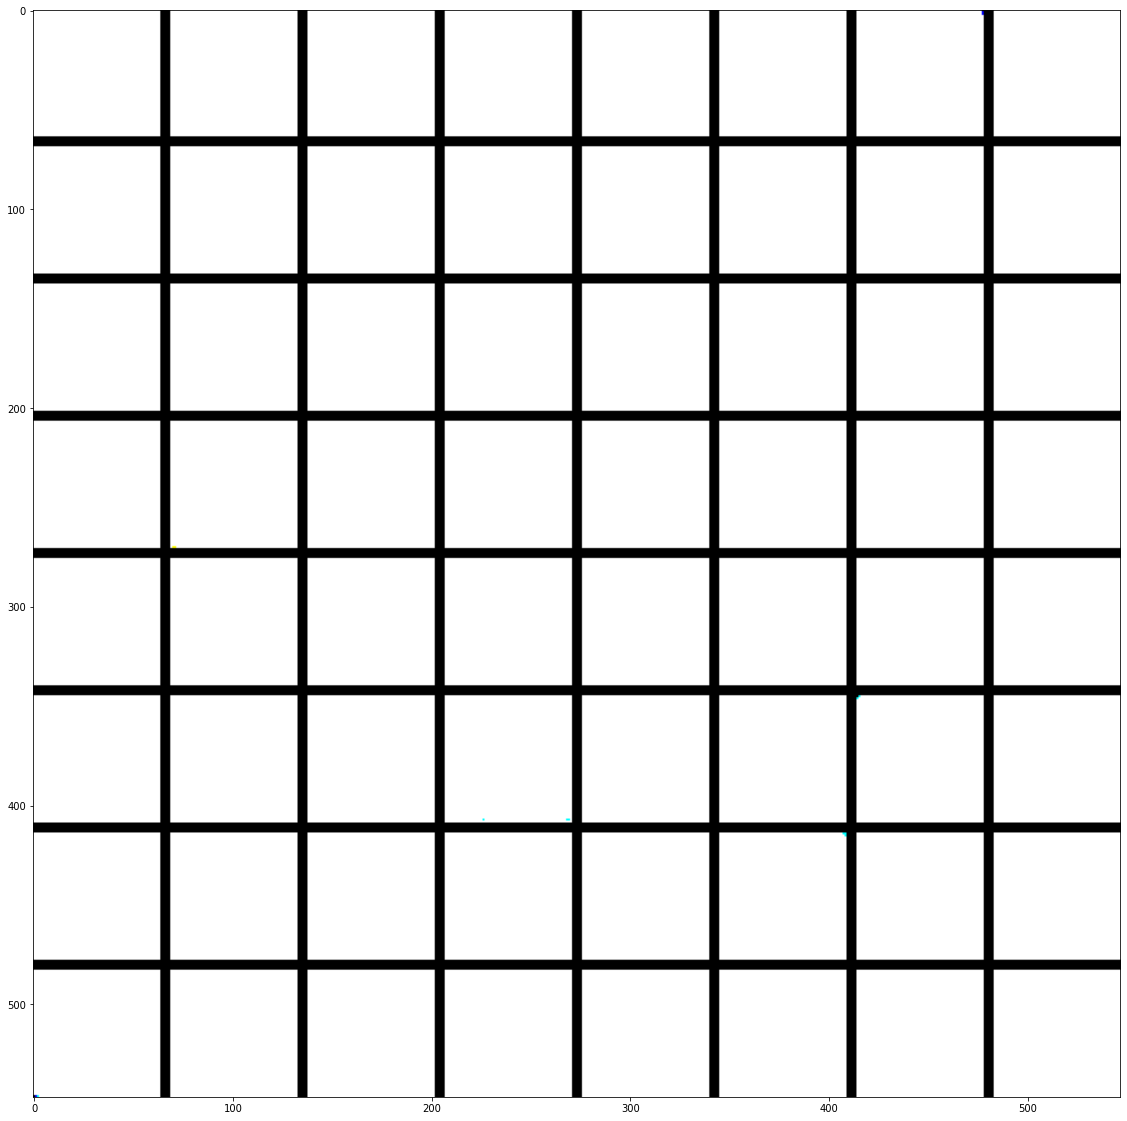

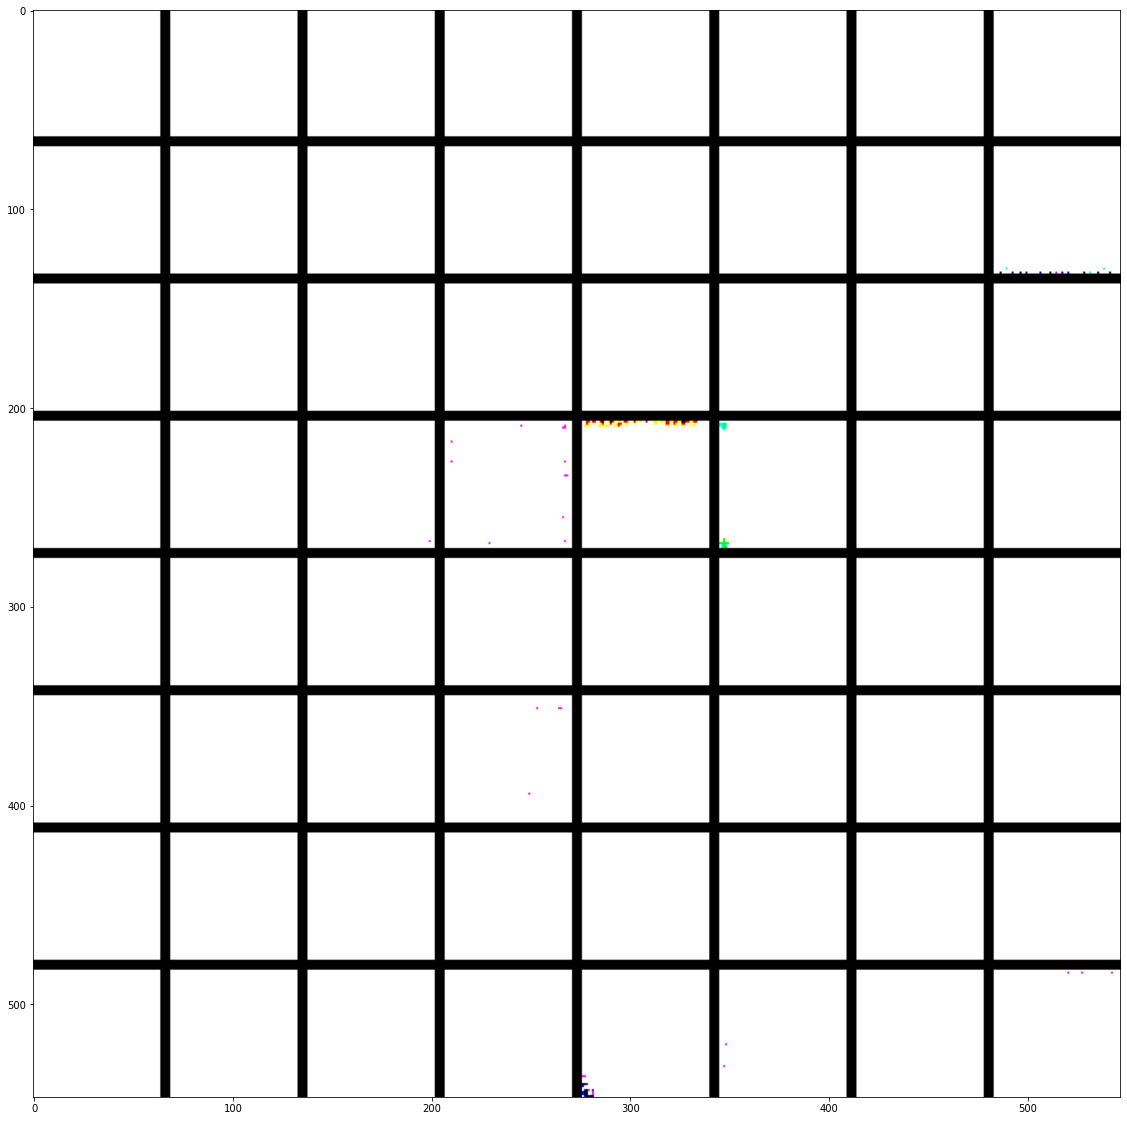

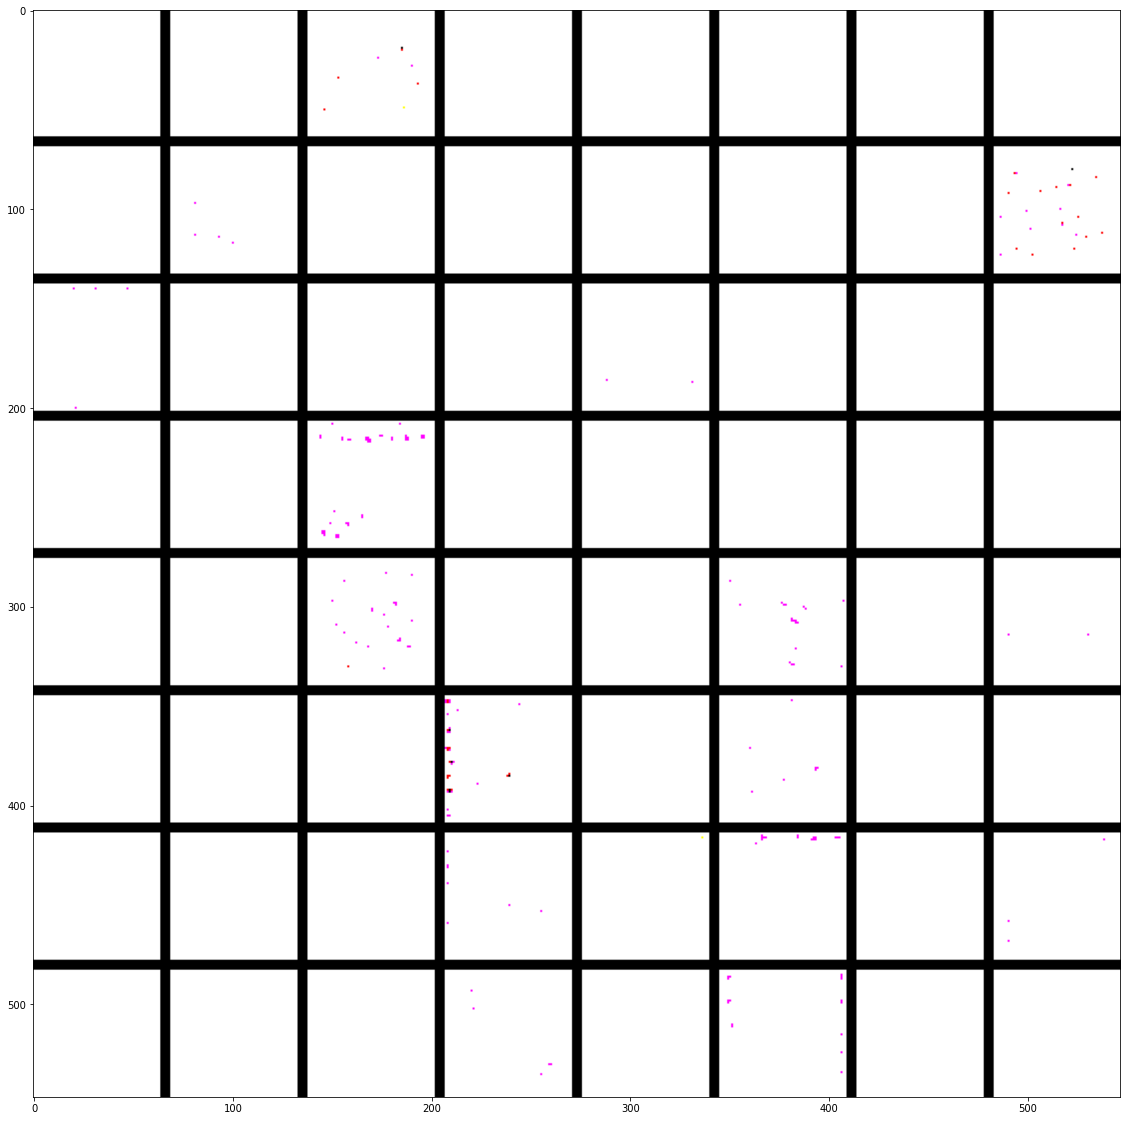

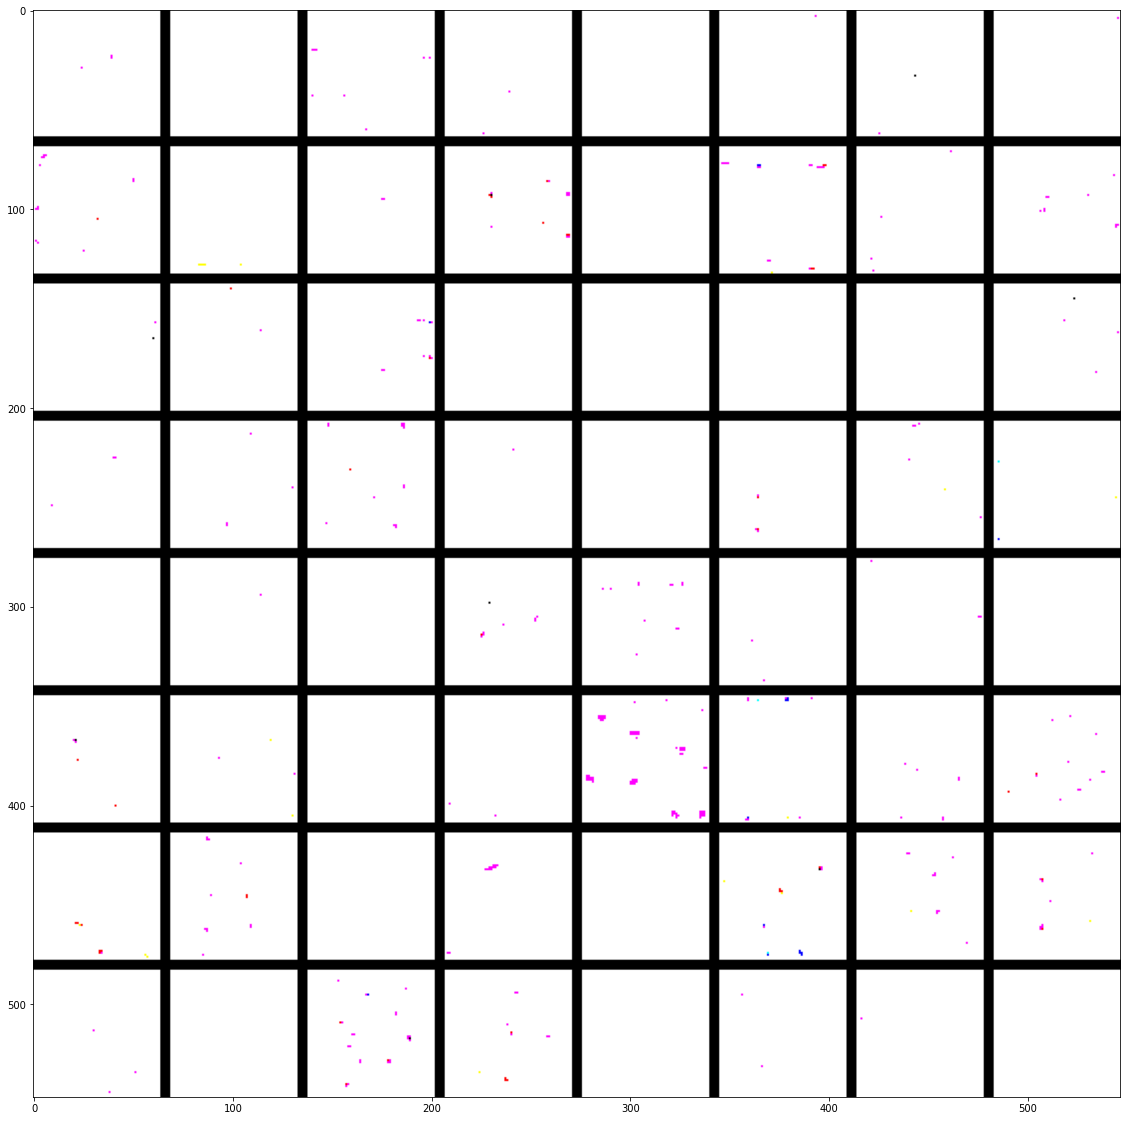

In [12]:
#產生每層中過濾器響應pattern
for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
    size = 64 #每格邊長
    margin = 5 #兩格之間間隔

    #用於儲存結果的空(黑色)影像
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(8): #迭代產生網格的列
        for j in range(8): #迭代產生網格的行
            #在layer_name中產生過濾器i+(j*8)的pattern
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

            #將結果放入(i,j)的網格陣列中
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    #顯示網格結果
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()

In [13]:
#過濾器視覺化呈現卷積層如何檢視資訊全貌
#model低層(1) -> 高層(n)的過濾器: 簡單的邊和顏色 -> 邊和顏色構成的簡單紋理 -> 接近自然影像的紋理(ex:羽毛、眼睛、樹葉...)